## Healthcare Stocks - Andy
Follow along the code to do the preliminary data analysis!\
**Please refer to the [meeting notes here](https://docs.google.com/document/d/1tnDnYfO5m5GQz5Fm7_TbpzHN9bG3RmvqpgvL4TyOevI/edit?usp=sharing) to get familiar with all the column names and the values associated with them.**

### Step 1: Install the necessary libraries for our data collection.
[yfinance](https://python-yahoofinance.readthedocs.io/en/latest/): used to fetch historical stock data (price, volume, etc.) from Yahoo Finance for our assigned sectors.\
[ta](https://technical-analysis-library-in-python.readthedocs.io/en/latest/): used to calculate technical indicators from the price data we get with yfinance. These indicators help our model understand:
- Trends (e.g., SMA, EMA, MACD)
- Momentum (e.g., RSI)
- Volatility (e.g., ATR, Bollinger Bands)
- Volume pressure (e.g., OBV)

In [1]:
!pip install yfinance
!pip install ta

  Using cached yfinance-0.2.55-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.9-py3-none-any.whl
Using cached yfinance-0.2.55-py2.py3-none-any.whl (109 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached ta-0.11.0-py3-none-any.whl



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 2: Import the necessary libraries

In [2]:
import yfinance as yf
import pandas as pd
import time
import ta

### Step 3: Collect Preliminary Stock Data Using `yfinance`

In this step, you will collect **5 years of historical daily stock data** for your assigned sector using the `yfinance` library.

**What this code does:**
- Loops through a list of stock tickers.
- Uses `yfinance` to download daily data for each stock over a 5-year period.
- Waits 3 seconds between requests to avoid hitting API limits.
- Cleans and formats the data: resets the index and adds a "Ticker" column.
- Stores all the data in one master DataFrame called `price_df`.

**What you need to do:**
- Replace the `tickers` list with the stocks **assigned to your sector**.
- You can find your list of stocks by referring to the excel file we created earlier [here](https://docs.google.com/spreadsheets/d/19n8ye_mwPM6QVbFJjG4eVUfiqUiGMQ-MujnMY_zMUs8/edit?usp=sharing).
- Run the code block to create your `price_df`, which you will later use for feature engineering.

If no data is found or an error occurs for a ticker, it will be skipped and reported in the output.\

*If you are running into errors with `yfinance` and hitting api limits, please wait a few hours and try running the code again. Please avoing running the cell multiple times to not run into this issue!*

Below is the code you should run (after customizing your ticker list):

In [4]:
# Refer back to the csv file to find the stocks you selected, and replace these tickers with your own.
tickers = [
    "JNJ", "PFE", "MRNA", "GILD", "REGN",
    "AMGN", "BIIB", "LLY", "BMY", "VRTX",
    "MDT", "ABT", "BDX", "TMO", "ISRG",
    "BSX", "UNH", "CVS", "CI", "HUM"
]


#CODE BELOW DOES NOT NEED TO BE CHANGED
# List to hold all data
all_data = []

# Loop through each ticker
for ticker in tickers:
    try:
        df = yf.Ticker(ticker).history(period="5y", interval="1d")
        time.sleep(3) # wait in between requests to avoid request limits
        if df.empty:
            print(f"No data for {ticker}")
            continue

        df = df.reset_index()  # Convert index to Date column
        df["Ticker"] = ticker  # Add ticker column
        all_data.append(df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]])
        print(f"{ticker} added")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Concatenate all into one DataFrame
price_df = pd.concat(all_data, ignore_index=True)

# Preview the result
print(price_df.head())

JNJ added
PFE added
MRNA added
GILD added
REGN added
AMGN added
BIIB added
LLY added
BMY added
VRTX added
MDT added
ABT added
BDX added
TMO added
ISRG added
BSX added
UNH added
CVS added
CI added
HUM added
                       Date Ticker        Open        High         Low  \
0 2020-04-13 00:00:00-04:00    JNJ  121.670556  122.965483  119.793350   
1 2020-04-14 00:00:00-04:00    JNJ  126.380996  128.119148  125.190367   
2 2020-04-15 00:00:00-04:00    JNJ  126.493948  128.544967  124.747098   
3 2020-04-16 00:00:00-04:00    JNJ  128.892611  130.952316  127.267444   
4 2020-04-17 00:00:00-04:00    JNJ  132.090811  132.360222  130.013721   

        Close    Volume  
0  121.470673   8153200  
1  126.911133  13838000  
2  128.327698  11962300  
3  130.074554  12181700  
4  132.116882  10920000  


### Step 4: Generate Price-Based and Technical Indicators

Now that you have your stock data, it’s time to create additional features that help the model understand market trends, volatility, and momentum.

**What this code does:**
- Calculates **daily returns** and **VWAP** (volume-weighted average price).
- Adds several **technical indicators** like:
  - Simple and Exponential Moving Averages (SMA, EMA)
  - Relative Strength Index (RSI)
  - MACD and Signal Line
  - Bollinger Bands (Upper and Lower)
  - Average True Range (ATR)
  - On-Balance Volume (OBV)
- Groups the data by ticker to apply indicator calculations correctly.
- Combines everything into a single DataFrame with all features.

**What you need to do:**
- You **do not need to modify anything** in this code block **except one thing**:
  - In the **last line**, rename the CSV file to reflect your assigned sector name:
    ```python
    tech_df.to_csv("your_sector_name_data_with_indicators.csv", index=False)
    ```

Once this is done, you’ll have a feature-rich dataset ready for modeling!

In [6]:
tech_df = price_df.copy()

# --- Price-based indicators ---
tech_df['Daily Return'] = tech_df.groupby("Ticker")['Close'].pct_change(fill_method=None)
tech_df['Typical Price'] = (tech_df['High'] + tech_df['Low'] + tech_df['Close']) / 3
tech_df['VWAP'] = (tech_df['Typical Price'] * tech_df['Volume']).groupby(tech_df['Ticker']).cumsum() / tech_df['Volume'].groupby(tech_df['Ticker']).cumsum()

# --- Technical indicators ---
grouped = tech_df.groupby("Ticker", group_keys=False)
tech_df['SMA_20'] = grouped['Close'].apply(lambda x: x.rolling(window=20).mean())
tech_df['EMA_20'] = grouped['Close'].apply(lambda x: x.ewm(span=20, adjust=False).mean())
tech_df['RSI_14'] = grouped['Close'].apply(lambda x: ta.momentum.RSIIndicator(close=x, window=14).rsi())
tech_df['MACD'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd())
tech_df['MACD_Signal'] = grouped['Close'].apply(lambda x: ta.trend.MACD(close=x).macd_signal())
tech_df['BB_Upper'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_hband())
tech_df['BB_Lower'] = grouped['Close'].apply(lambda x: ta.volatility.BollingerBands(close=x, window=20).bollinger_lband())
# Create empty columns
tech_df['ATR'] = None
tech_df['OBV'] = None

# Loop through each group (ticker) and calculate indicators
result_frames = []

for ticker, group in tech_df.groupby("Ticker"):
    group = group.copy()
    group.sort_values('Date', inplace=True)

    # ATR
    atr = ta.volatility.AverageTrueRange(
        high=group['High'],
        low=group['Low'],
        close=group['Close']
    ).average_true_range()
    group['ATR'] = atr

    # OBV
    obv = ta.volume.OnBalanceVolumeIndicator(
        close=group['Close'],
        volume=group['Volume']
    ).on_balance_volume()
    group['OBV'] = obv

    result_frames.append(group)

# Combine the updated groups back together
tech_df = pd.concat(result_frames, ignore_index=True)

# Save to CSV, rename it to correspond to your sector. Please replace "sector" with your corresponding sector.
tech_df.to_csv("Healthcare_data_with_indicators.csv", index=False)

## Exploratory Data Analysis (EDA)

Load the csv you just created, and give it a name. Replace the csv name (what is in quoets ""), with the csv you created above.

In [15]:
healthcare_df = pd.read_csv("Healthcare_data_with_indicators.csv")
healthcare_df.head() #shows first 5 rows of data frame

,Date,Ticker,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
0,2020-04-13 00:00:00-04:00,ABT,79.033829,79.180327,76.470171,78.603500,6665800,NaN,78.084666,78.084666,NaN,78.603500,NaN,NaN,NaN,NaN,NaN,0.0,6665800
1,2020-04-14 00:00:00-04:00,ABT,79.991857,82.327253,79.532134,81.959473,9861300,0.042695,81.272953,79.987036,NaN,78.923117,NaN,NaN,NaN,NaN,NaN,0.0,16527100
2,2020-04-15 00:00:00-04:00,ABT,82.759401,84.497155,81.380231,83.614487,14128000,0.020193,83.163957,81.451182,NaN,79.369914,NaN,NaN,NaN,NaN,NaN,0.0,30655100
3,2020-04-16 00:00:00-04:00,ABT,85.140764,89.177134,83.798372,88.266884,27036500,0.055641,87.080797,84.089436,NaN,80.217244,NaN,NaN,NaN,NaN,NaN,0.0,57691600
4,2020-04-17 00:00:00-04:00,ABT,89.600083,89.875920,86.648660,88.276085,16074800,0.000104,88.266888,84.999765,NaN,80.984753,NaN,NaN,NaN,NaN,NaN,0.0,73766400


In [16]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Data Handling
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings for nicer visuals
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)

### EDA Guidelines

Follow these steps to explore and understand your dataset before modeling. This will help uncover patterns, identify issues, and engineer features that improve performance.

**Resources (Videos):**
- [Learn EDA - Playlist](https://www.youtube.com/watch?v=78ut-S-QOEQ&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&ab_channel=MarkKeith)
- [Complete Exploratory Data Analysis And Feature Engineering In 3 Hours| Krish Naik](https://youtu.be/fHFOANOHwh8?si=1SRsxlRJpOlUGMhI)
- [How to Do Data Exploration (step-by-step tutorial on real-life dataset)](https://youtu.be/OY4eQrekQvs?si=i1QzaMrCFQmxg1uJ)

#### 1) Get Rid of Any Null Values If You Have Any

- First, check for missing (`NaN`) values across all columns.
- If there are only a few missing entries, drop them.
- **Resource**: [A Guide to Handling Missing values in Python](https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python)

```python
# Check for null values
healthcare_df.isnull().sum()

# Drop rows with any nulls (simple but aggressive)
healthcare_df = df.dropna()

In [20]:
healthcare_df.isnull().sum()
healthcare_df = healthcare_df.dropna()

#### 2) Inspect Your Overall Cleaned Dataset Using Summary Statistics
- Use `.info()` and `.describe()` to understand the shape, datatypes, and distributions of the dataset.
- This gives a high-level snapshot of numeric features and potential outliers or irregularities.
- **Resource:**: [An Introduction To Summary Statistics In Python (With Code Examples)](https://zerotomastery.io/blog/summary-statistics-in-python/)

In [21]:
healthcare_df.info()
healthcare_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 24480 entries, 33 to 25139
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           24480 non-null  object 
 1   Ticker         24480 non-null  object 
 2   Open           24480 non-null  float64
 3   High           24480 non-null  float64
 4   Low            24480 non-null  float64
 5   Close          24480 non-null  float64
 6   Volume         24480 non-null  int64  
 7   Daily Return   24480 non-null  float64
 8   Typical Price  24480 non-null  float64
 9   VWAP           24480 non-null  float64
 10  SMA_20         24480 non-null  float64
 11  EMA_20         24480 non-null  float64
 12  RSI_14         24480 non-null  float64
 13  MACD           24480 non-null  float64
 14  MACD_Signal    24480 non-null  float64
 15  BB_Upper       24480 non-null  float64
 16  BB_Lower       24480 non-null  float64
 17  ATR            24480 non-null  float64
 18  OBV       

,Open,High,Low,Close,Volume,Daily Return,Typical Price,VWAP,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Upper,BB_Lower,ATR,OBV
count,24480.000000,24480.000000,24480.000000,24480.000000,2.448000e+04,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,24480.000000,2.448000e+04
mean,245.968463,248.774030,243.104052,245.968216,5.852329e+06,0.000375,245.948766,212.949806,245.305679,245.282704,51.329802,0.550543,0.569414,259.295985,231.315372,6.009824,9.086871e+07
std,200.559591,202.763998,198.232276,200.517835,9.036215e+06,0.019456,200.493453,153.999921,199.758189,199.604520,12.442440,6.322829,5.918708,211.230910,188.871374,5.303178,1.798216e+08
min,21.110001,22.270000,20.920000,21.590000,0.000000e+00,-0.281666,21.650000,27.253355,24.539409,24.188462,11.991832,-61.348669,-59.004736,25.530831,21.664656,0.429267,-1.051660e+09
25%,79.911163,80.649238,79.063282,79.917637,1.425875e+06,-0.008403,79.810928,72.750983,79.737464,79.862450,42.509050,-1.408848,-1.279608,84.077013,75.492933,1.664818,1.008210e+07
50%,209.694741,212.474118,206.974998,209.606758,3.125200e+06,0.000401,209.694354,203.555754,210.081905,210.504731,51.265688,0.212740,0.214447,221.572750,195.402282,4.692168,5.266970e+07
75%,339.992493,344.205995,336.262561,340.333748,6.741050e+06,0.009086,339.989564,276.083533,337.519732,338.319046,60.117476,2.315122,2.221022,356.917822,318.856612,8.664786,1.662536e+08
max,1203.173810,1209.645477,1195.593589,1200.217651,3.499965e+08,0.439739,1201.818906,681.482521,1173.814581,1163.073484,90.293434,52.675644,43.835452,1247.687772,1130.946236,37.568173,8.581766e+08


#### 3) Create Plots to Explore Distributions
Plot histograms and KDE plots to check how features like RSI, MACD, and Volume, etc. are distributed. This helps you spot skewness, spikes, and potential transformations.
**Resources**: 
- [Seaborn Kdeplot - A Comprehensive Guide](https://www.digitalocean.com/community/tutorials/seaborn-kdeplot)
- [Python Histogram Plotting: NumPy, Matplotlib, pandas & Seaborn](https://realpython.com/python-histograms/)

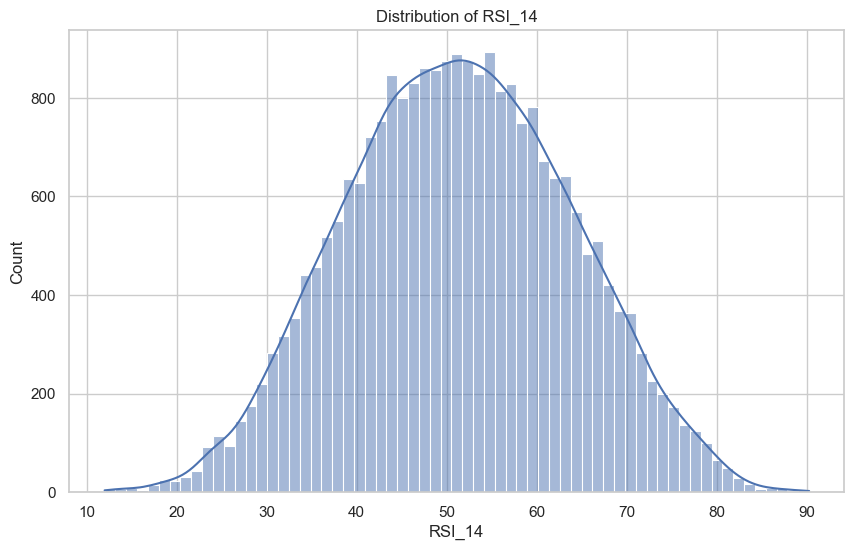

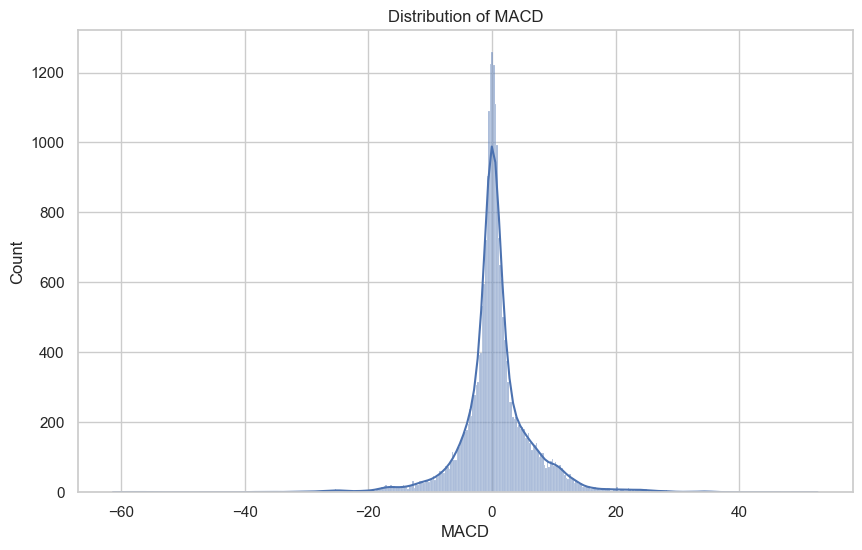

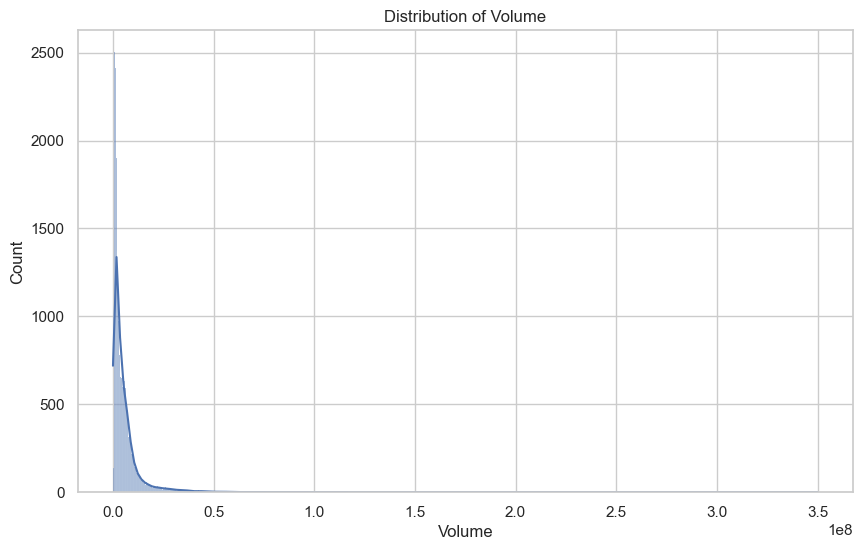

In [24]:
lst = ["RSI_14", "MACD", "Volume"]
for e in lst:
    sns.histplot(data=healthcare_df, x=e, kde=True)
    plt.title(f"Distribution of {e}")
    plt.xlabel(e)
    plt.show()

#### 4) Generate a Correlation Heatmap to Spot Redundant Features
Highly correlated features can be redundant and may hurt certain models. Use a heatmap to visually inspect correlation between numerical features.
- **Resource**: [5 Minute EDA: Correlation Heatmap](https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14)

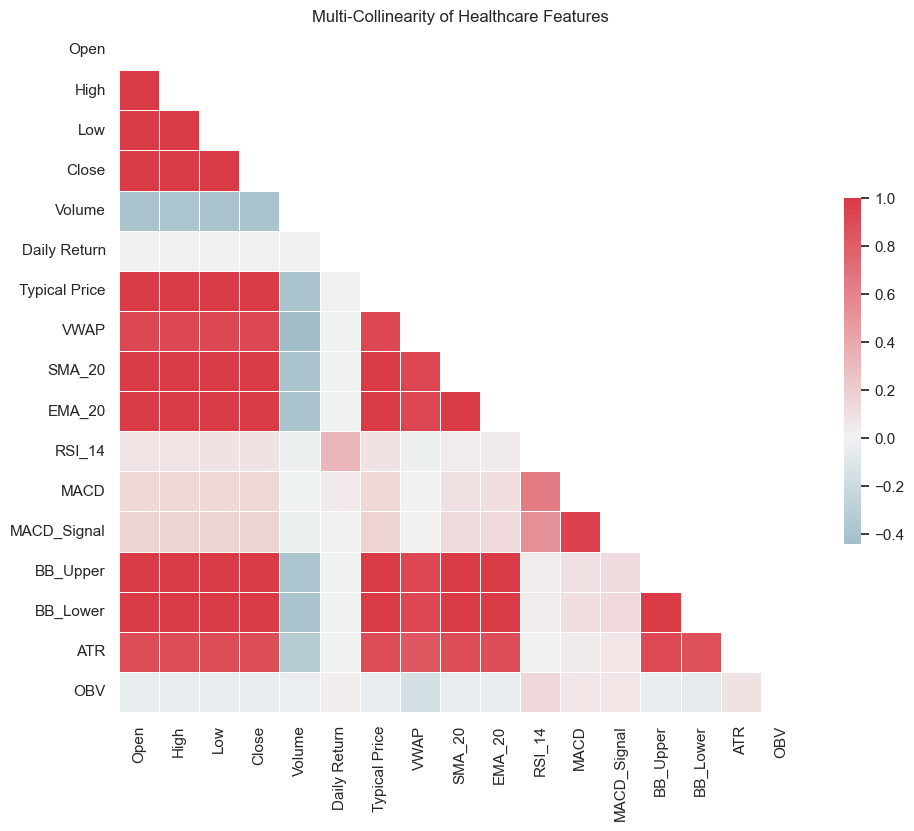

In [28]:
sns.set(style="white")
numerical = healthcare_df.select_dtypes(include='number')
corr = numerical.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
ax.set_title("Multi-Collinearity of Healthcare Features")
plt.show()

#### 5) Check the Relationship Between Features and the Target
Explore how technical indicators relate to the target (next day’s close). Use scatter plots or group-by summaries to spot patterns.
- **Resource**: [Scatter plot with a grouping variable with Pandas](https://python-graph-gallery.com/537-scatter-plots-grouped-by-color-with-pandas/)

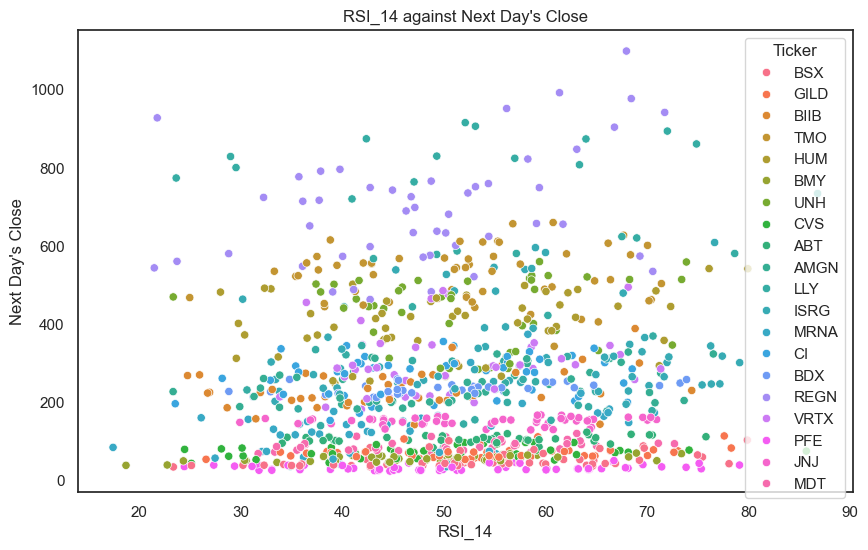

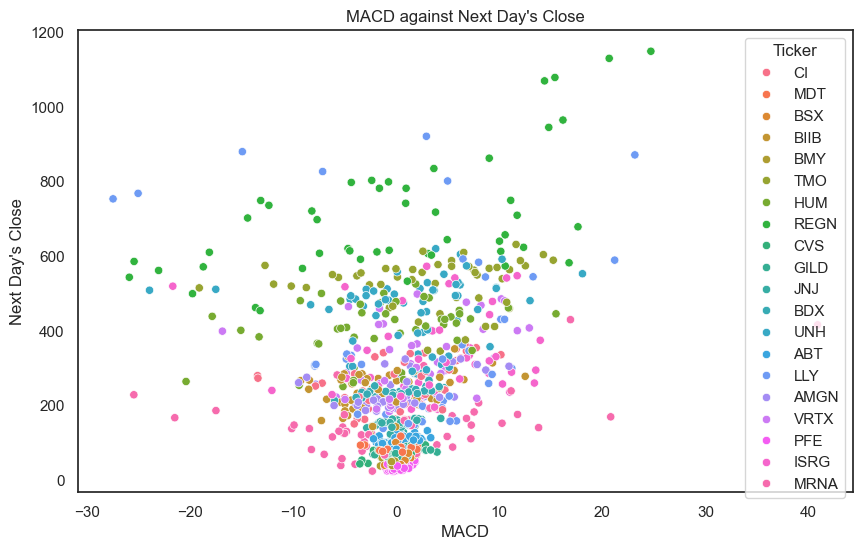

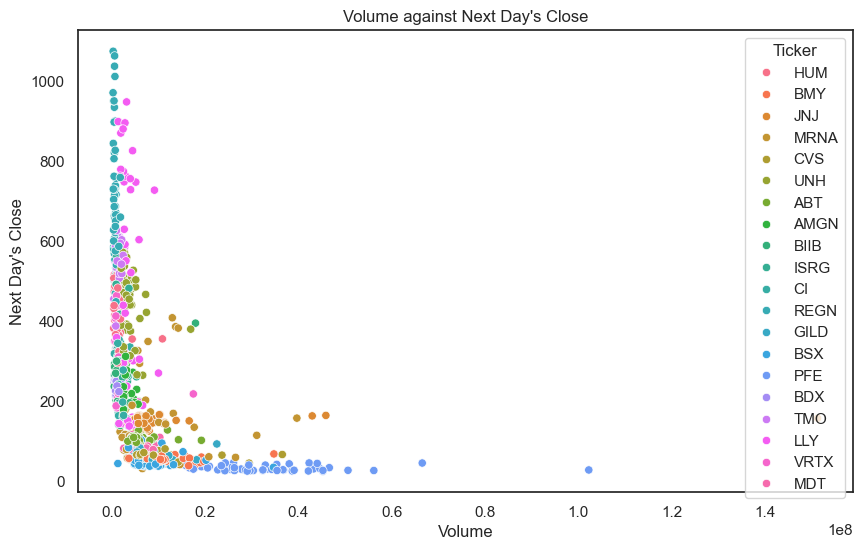

In [34]:
healthcare_df["Next Day's Close"] = healthcare_df.groupby("Ticker")["Close"].shift(-1)
for e in lst:
    sns.scatterplot(data=healthcare_df.sample(1000), x=e, y="Next Day's Close", hue="Ticker")
    plt.title(f"{e} against Next Day's Close")
    plt.show()

#### 6) Use Boxplots to Detect Outliers
- Boxplots are a great way to spot extreme values or outliers in numeric features. 
- Outliers can influence your model heavily — decide whether to keep, remove, or transform them.
- **Resource**: [How to detect outliers using IQR and Boxplots?](https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-using-iqr-and-boxplots/)

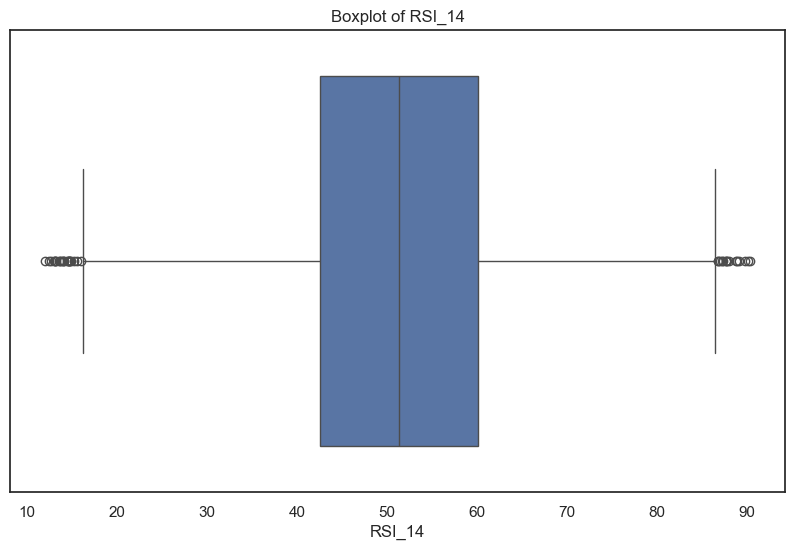

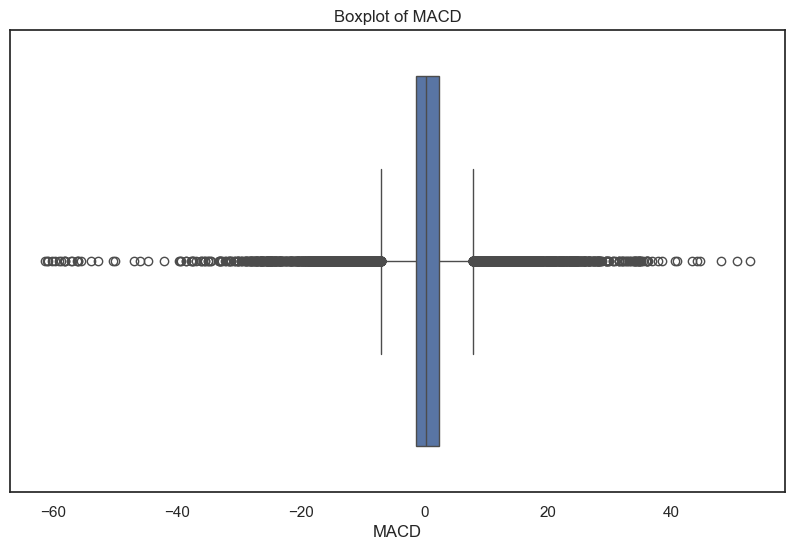

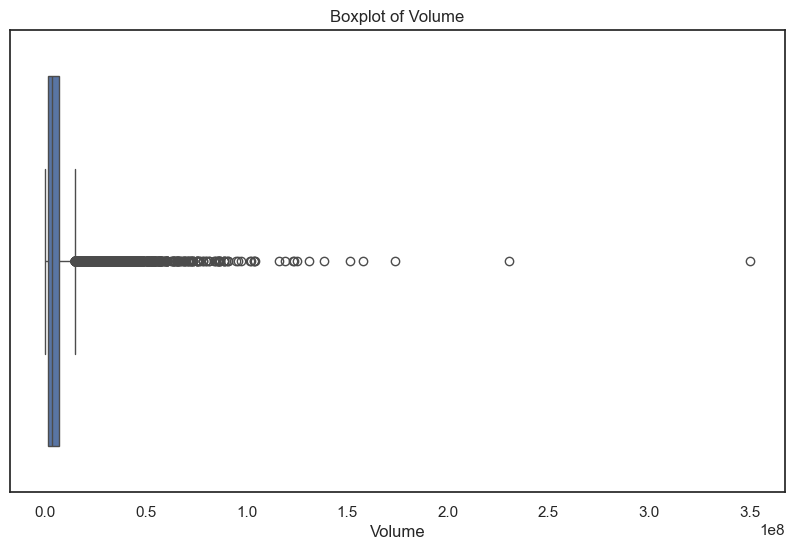

In [37]:
for e in lst:
    sns.boxplot(x=healthcare_df[e])
    plt.title(f"Boxplot of {e}")
    plt.show()
    Q1 = healthcare_df[e].quantile(0.25)
    Q3 = healthcare_df[e].quantile(0.75)
    outliers = healthcare_df[(healthcare_df[e] < Q1 - 1.5 * (Q3 - Q1) | (healthcare_df[e] > Q3 + 1.5 * (Q3 - Q1)]
    

#### 7) Investigate Patterns Over Time or Between Groups (Sector, Ticker, etc.)
- Use time-based plots to see if the target or indicators change by day of the week or over time.
- Grouped boxplots can help reveal differences between companies or sectors.
- **Resource**: [Python Plotting for Exploratory Data Analysis](https://pythonplot.com/)

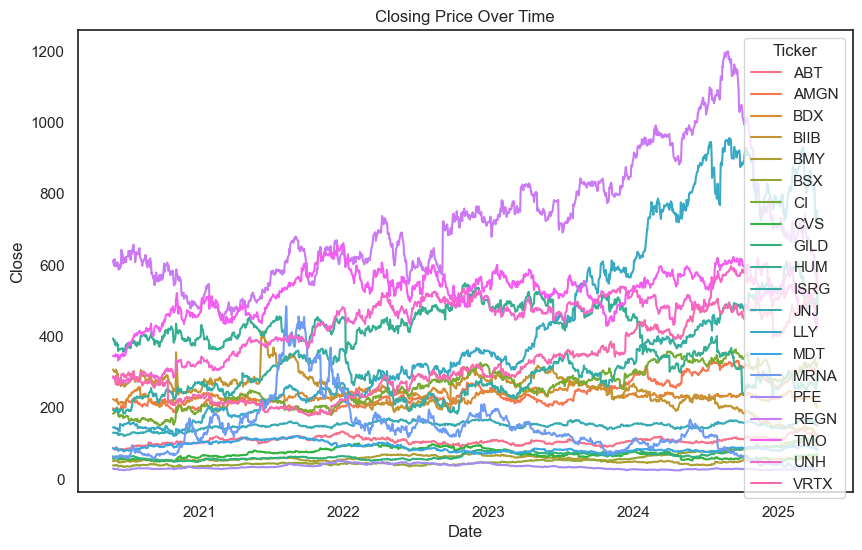

In [40]:
sns.lineplot(data=healthcare_df, x="Date", y="Close", hue="Ticker")
plt.title("Closing Price Over Time")
plt.show()

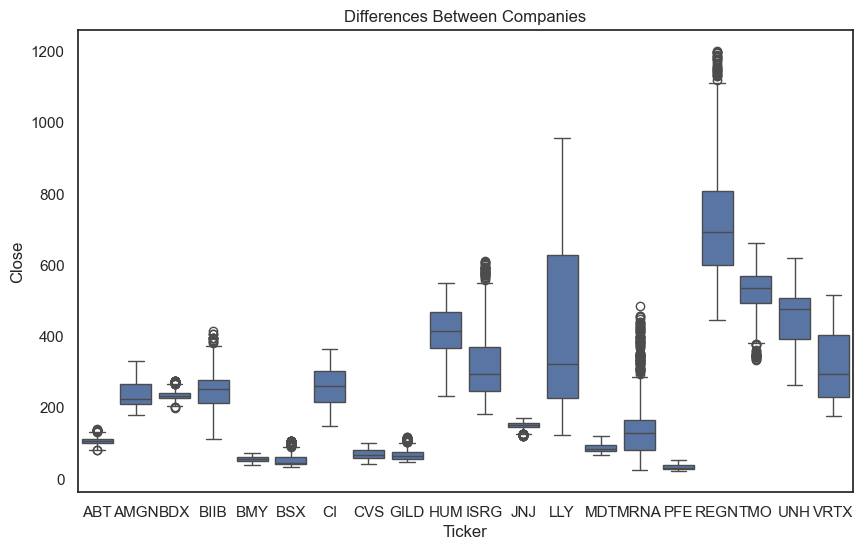

In [42]:
sns.boxplot(data=healthcare_df, x="Ticker", y="Close")
plt.title("Differences Between Companies")
plt.show()

#### 8) Brainstorm & Engineer New Features Based on Your Insights
- Consider creating features like price range, volatility, lagged prices, or differences from moving averages.
- These can help capture patterns not directly visible in raw features.
- **Resource**: [A Reference Guide to Feature Engineering](https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods)

In [45]:
healthcare_df["Price Range"] = healthcare_df["High"] - healthcare_df["Low"]
healthcare_df["Lagged Price"] = healthcare_df.groupby("Ticker")["Close"].shift(1)
healthcare_df["Difference From SMA_20"] = healthcare_df["Close"] - healthcare_df["SMA_20"]
healthcare_df["Difference From EMA_20"] = healthcare_df["Close"] - healthcare_df["EMA_20"]
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24480 entries, 33 to 25139
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    24480 non-null  object 
 1   Ticker                  24480 non-null  object 
 2   Open                    24480 non-null  float64
 3   High                    24480 non-null  float64
 4   Low                     24480 non-null  float64
 5   Close                   24480 non-null  float64
 6   Volume                  24480 non-null  int64  
 7   Daily Return            24480 non-null  float64
 8   Typical Price           24480 non-null  float64
 9   VWAP                    24480 non-null  float64
 10  SMA_20                  24480 non-null  float64
 11  EMA_20                  24480 non-null  float64
 12  RSI_14                  24480 non-null  float64
 13  MACD                    24480 non-null  float64
 14  MACD_Signal             24480 non-null  fl